In [2]:

import spacy

nlp = spacy.load("en_core_web_sm")


# Load Data set

In [3]:
import pandas as pd
import json


In [4]:
df = pd.read_csv("data/yoda_sentences_normalized.csv")

# If the mapping column is stored as a JSON string, convert it to a Python list.
df["mapping"] = df["mapping"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Word Order

In [5]:

def extract_labels_from_sentence(sentence: str) -> list:
    """
    Parse a canonical English sentence and assign each token a label:
      - 'S' for subject (nsubj or nsubjpass)
      - 'V' for main verb (ROOT)
      - 'O' for object (dobj, attr, or pobj)
      - 'X' for any other token
    Returns:
      A list of labels corresponding to each token in the sentence.
    """
    doc = nlp(sentence)
    labels = []
    for token in doc:
        if token.dep_ in ("nsubj", "nsubjpass"):
            labels.append("S")
        elif token.dep_ == "ROOT":
            labels.append("V")
        elif token.dep_ in ("dobj", "attr", "pobj"):
            labels.append("O")
        else:
            labels.append("X")
    return labels


In [6]:
def print_dep_labels(sentence: str):
    doc = nlp(sentence)
    dep_labels = []

    for token in doc:
        dep_labels.append(token.dep_)

    return dep_labels

In [7]:
def map_labels_by_mapping(norm_labels: list, mapping: list[int]) -> list:
    """
    Reorder the list of normalized labels to match the original Yoda sentence using the mapping.
    
    Args:
        norm_labels: List of labels for the normalized sentence.
        mapping: List of integers where mapping[i] is the index of the token in the original Yoda sentence 
                 corresponding to the normalized token at position i.
    
    Returns:
        A list of labels ordered by the original Yoda sentence.
    """
    # Determine length of original sentence (assume max index + 1)
    n = max(mapping) + 1 if mapping else 0
    original_labels = [None] * n
    for norm_idx, orig_idx in enumerate(mapping):
        original_labels[orig_idx] = norm_labels[norm_idx]
    return original_labels

In [8]:
def infer_word_order_from_labels(mapped_labels: list) -> str:
    """
    Given a list of labels (for the original sentence), extract the order of S (subject), V (verb), and O (object)
    by filtering out tokens that are not S, V, or O.
    
    Returns:
        A string representing the word order (e.g. 'OSV'). If one or more roles are missing, appends ' (Incomplete)'.
    """
    order_tokens = [label for label in mapped_labels if label in ("S", "V", "O")]
    incomplete = ""
    if not all(role in order_tokens for role in ("S", "V", "O")):
        incomplete = " (Incomplete)"
    return "".join(order_tokens) + incomplete

In [10]:
normalized_sentence = "He is your father."
example_mapping = [2, 3, 0, 1]  

norm_labels = extract_labels_from_sentence(normalized_sentence)
print("Normalized labels:", norm_labels)
# e.g., output might be: ['S', 'V', 'X', 'O'] 

# 2. Map these labels to the original Yoda sentence order.
mapped_labels = map_labels_by_mapping(norm_labels, example_mapping)
print("Mapped labels:", mapped_labels)
# e.g., the list might become: ['O', 'O', 'S', 'V'] 

# 3. Infer the word order from the mapped labels.
word_order = infer_word_order_from_labels(mapped_labels)
print("Inferred Yoda word order:", word_order)

Normalized labels: ['S', 'V', 'X', 'O', 'X']
Mapped labels: ['X', 'O', 'S', 'V']
Inferred Yoda word order: OSV


In [9]:
def infer_yoda_word_order(row) -> str:
    """
    Given a DataFrame row with columns 'normal_english' and 'mapping',
    computes the Yoda word order using our three-step process.
    """
    normal_text = row["normal_english"]
    mapping = row["mapping"]
    # 1. Extract labels from the normalized sentence
    norm_labels = extract_labels_from_sentence(normal_text)
    # 2. Map these labels to the original Yoda sentence using the provided mapping
    mapped_labels = map_labels_by_mapping(norm_labels, mapping)
    # 3. Infer the word order from the mapped labels
    word_order = infer_word_order_from_labels(mapped_labels)
    return word_order

In [ ]:
def infer_normal_word_order(normal_text: str) -> str:
    """
    Computes the word order of a canonical English sentence by:
      1. Extracting token labels from the sentence.
      2. Filtering for S, V, and O tokens in order.
    """
    norm_labels = extract_labels_from_sentence(normal_text)
    return infer_word_order_from_labels(norm_labels)

In [13]:
df_copy = df.copy()

df_copy["normal_word_order"] = df_copy["normal_english"].apply(infer_normal_word_order)
df_copy["yoda_word_order"] = df_copy.apply(infer_yoda_word_order, axis=1)


In [17]:
display(df_copy[["original", "normal_english", "mapping", "yoda_word_order", "normal_word_order"]].head(10))

,original,normal_english,mapping,yoda_word_order,normal_word_order
0,"the very republic is threatened, if involved t...","if the sith are involved, the very republic is...","[5, 7, 8, 9, 6, 0, 1, 2, 3, 4]",SS (Incomplete),SSV (Incomplete)
1,"hard to see, the dark side is.",The dark side is hard to see.,"[3, 4, 5, 6, 0, 1, 2]",SV (Incomplete),SV (Incomplete)
2,"discover who this assassin is, we must.",We must discover who this assassin is.,"[5, 6, 0, 1, 2, 3, 4]",VOSS,SVOS
3,"with this naboo queen you must stay, qui-gon.","Qui-gon, you must stay with this naboo queen.","[7, 4, 5, 6, 0, 1, 2, 3]",SV (Incomplete),SVO
4,protect her.,Protect her.,"[0, 1]",VO (Incomplete),VO (Incomplete)
5,may the force be with you.,May the force be with you.,"[0, 1, 2, 3, 4, 5]",SVO,SVO
6,(cont'd) master qui-gon more to say have you?,"You have more to say, master Qui-Gon (cont'd)?","[7, 6, 3, 4, 5, 1, 2, 0]",OVS,SVOO
7,"a vergence, you say?",You say a vergence?,"[2, 3, 0, 1]",OSV,SVO
8,but you do!,You do but!,"[1, 2, 0]",SV (Incomplete),SV (Incomplete)
9,rrevealed your opinion is.,Your opinion is rrevealed.,"[1, 2, 3, 0]",VS (Incomplete),SV (Incomplete)


In [38]:
print_dep_labels("He is your father.")

['nsubj', 'ROOT', 'poss', 'attr', 'punct']

In [14]:
ex = extract_labels_from_sentence("He is your father.")
print(ex)

['S', 'V', 'X', 'O', 'X']


In [15]:
map_labels_by_mapping(ex, [2,3,0,1])

['X', 'O', 'S', 'V']

In [18]:
import json

In [19]:
df_to_save = df_copy.copy()
df_to_save['mapping'] = df_to_save['mapping'].apply(json.dumps)

df_to_save.to_csv("data/yoda_word_order.csv", index=False)

# Analysis

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
word_order_df = pd.read_csv("data/yoda_word_order.csv")

# If the mapping column is stored as a JSON string, convert it to a Python list.
word_order_df["mapping"] = word_order_df["mapping"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

In [11]:
normal_counts = word_order_df["normal_word_order"].value_counts(normalize=True) * 100
yoda_counts   = word_order_df["yoda_word_order"].value_counts(normalize=True) * 100

In [ ]:
# all word orders
all_categories = set(normal_counts.index).union(set(yoda_counts.index))

In [14]:
threshold = 5

categories_to_investigate = [
    cat for cat in all_categories
    if normal_counts.get(cat, 0) >= threshold or yoda_counts.get(cat, 0) >= threshold
]

print("Categories to Investigate:")
for cat in categories_to_investigate:
    norm_pct = normal_counts.get(cat, 0)
    yoda_pct = yoda_counts.get(cat, 0)
    print(f"{cat}: Normal English = {norm_pct:.2f}%, Yoda Speech = {yoda_pct:.2f}%")



Categories to Investigate:
VOS: Normal English = 0.00%, Yoda Speech = 8.99%
OSV: Normal English = 0.56%, Yoda Speech = 11.24%
SVO: Normal English = 29.21%, Yoda Speech = 6.74%
SVOO: Normal English = 10.11%, Yoda Speech = 1.69%
VS (Incomplete): Normal English = 1.12%, Yoda Speech = 8.99%
V (Incomplete): Normal English = 10.67%, Yoda Speech = 11.80%
VO (Incomplete): Normal English = 8.43%, Yoda Speech = 6.18%
SV (Incomplete): Normal English = 16.29%, Yoda Speech = 11.80%


In [17]:
# Calculate aggregated percentage for 'Other' categories.
def aggregate_others(counts, investigated):
    others = sum([pct for cat, pct in counts.items() if cat not in investigated])
    return others

other_normal = aggregate_others(normal_counts, categories_to_investigate)
other_yoda   = aggregate_others(yoda_counts, categories_to_investigate)


Aggregated Word Order Distribution (including 'Other'):
                 Normal English  Yoda Speech
Other                 23.595506    32.584270
SVO                   29.213483     6.741573
SV (Incomplete)       16.292135    11.797753
V (Incomplete)        10.674157    11.797753
VO (Incomplete)        8.426966     6.179775
OSV                    0.561798    11.235955
SVOO                  10.112360     1.685393
VS (Incomplete)        1.123596     8.988764
VOS                    0.000000     8.988764


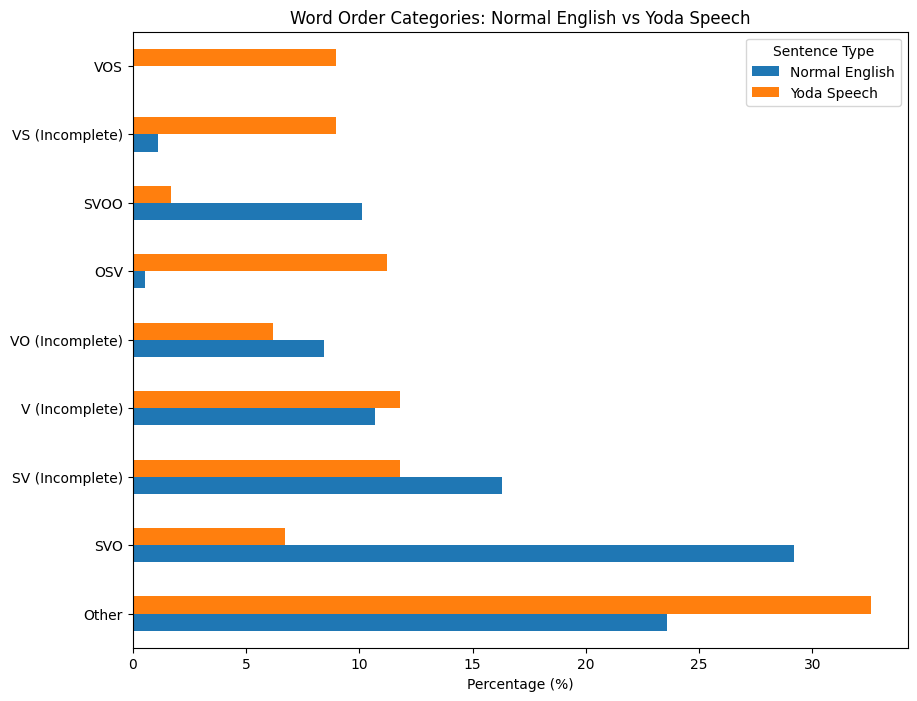

In [19]:
investigate_df = pd.DataFrame({
    "Normal English": {cat: normal_counts.get(cat, 0) for cat in categories_to_investigate},
    "Yoda Speech": {cat: yoda_counts.get(cat, 0) for cat in categories_to_investigate}
})

investigate_df.loc["Other"] = [other_normal, other_yoda]

# Sort by total frequency (sum of Normal English and Yoda percentages)
investigate_df["Total"] = investigate_df["Normal English"] + investigate_df["Yoda Speech"]
investigate_df = investigate_df.sort_values("Total", ascending=False).drop(columns="Total")

print("\nAggregated Word Order Distribution (including 'Other'):")
print(investigate_df)

# Plot a horizontal bar chart for easier reading
ax = investigate_df.plot(kind="barh", figsize=(10, 8))
ax.set_xlabel("Percentage (%)")
ax.set_title("Word Order Categories: Normal English vs Yoda Speech")
plt.legend(title="Sentence Type")
plt.show()

In [31]:
print("\nYoda Speech Word Order Distribution:")
for order, pct in yoda_counts.sort_values(ascending=False).items():
    print(f"{order}: {pct:.2f}%")


Yoda Speech Word Order Distribution:
V (Incomplete): 11.80%
SV (Incomplete): 11.80%
OSV: 11.24%
VS (Incomplete): 8.99%
VOS: 8.99%
SVO: 6.74%
VO (Incomplete): 6.18%
OVS: 3.37%
OV (Incomplete): 2.81%
OSVO: 2.25%
VSO: 1.69%
OOSV: 1.69%
SVOO: 1.69%
SVS (Incomplete): 1.69%
OVO (Incomplete): 1.69%
OOOSV: 1.12%
VSOOS: 1.12%
SOS (Incomplete): 1.12%
VOSS: 0.56%
SVOOSV: 0.56%
VSVO: 0.56%
OOVSS: 0.56%
OSVS: 0.56%
VOO (Incomplete): 0.56%
SOSVO: 0.56%
OVOOS: 0.56%
VOOS: 0.56%
SOVO: 0.56%
OSOVO: 0.56%
OOVS: 0.56%
SOOSV: 0.56%
OOVSO: 0.56%
SS (Incomplete): 0.56%
SSV (Incomplete): 0.56%
OOV (Incomplete): 0.56%
VVS (Incomplete): 0.56%
SSO (Incomplete): 0.56%
VSOOO: 0.56%
S (Incomplete): 0.56%
OOOV (Incomplete): 0.56%
SOVSO: 0.56%
VOSOS: 0.56%
OS (Incomplete): 0.56%


In [33]:
print("\nYoda Speech Word Order Distribution:")
for order, pct in yoda_counts.sort_values(ascending=False).items():
    print(f"{order}, ", end="")


Yoda Speech Word Order Distribution:
V (Incomplete), SV (Incomplete), OSV, VS (Incomplete), VOS, SVO, VO (Incomplete), OVS, OV (Incomplete), OSVO, VSO, OOSV, SVOO, SVS (Incomplete), OVO (Incomplete), OOOSV, VSOOS, SOS (Incomplete), VOSS, SVOOSV, VSVO, OOVSS, OSVS, VOO (Incomplete), SOSVO, OVOOS, VOOS, SOVO, OSOVO, OOVS, SOOSV, OOVSO, SS (Incomplete), SSV (Incomplete), OOV (Incomplete), VVS (Incomplete), SSO (Incomplete), VSOOO, S (Incomplete), OOOV (Incomplete), SOVSO, VOSOS, OS (Incomplete), 

                   Normal English  Yoda Speech
OOOSV                    0.000000     1.123596
OOOV (Incomplete)        0.000000     0.561798
OOSV                     0.000000     1.685393
OOSVSO                   0.561798     0.000000
OOV (Incomplete)         0.000000     0.561798
...                           ...          ...
VSOOO                    0.561798     0.561798
VSOOS                    0.000000     1.123596
VSVO                     0.561798     0.561798
VV (Incomplete)          1.123596     0.000000
VVS (Incomplete)         0.000000     0.561798

[64 rows x 2 columns]


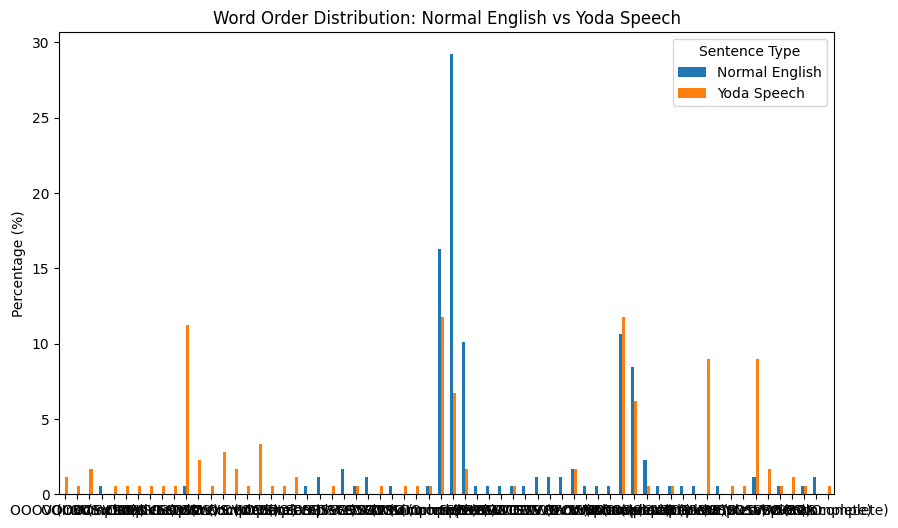

In [23]:
normal_counts = word_order_df["normal_word_order"].value_counts(normalize=True) * 100
yoda_counts   = word_order_df["yoda_word_order"].value_counts(normalize=True) * 100

# Combine the two into a single DataFrame for easier plotting.
combined_df = pd.DataFrame({
    "Normal English": normal_counts,
    "Yoda Speech": yoda_counts
}).fillna(0)  # fill missing categories with 0

print(combined_df)

# Plot the distributions side by side.
ax = combined_df.plot(kind="bar", figsize=(10, 6))
ax.set_ylabel("Percentage (%)")
ax.set_title("Word Order Distribution: Normal English vs Yoda Speech")
plt.xticks(rotation=0)
plt.legend(title="Sentence Type")
plt.show()

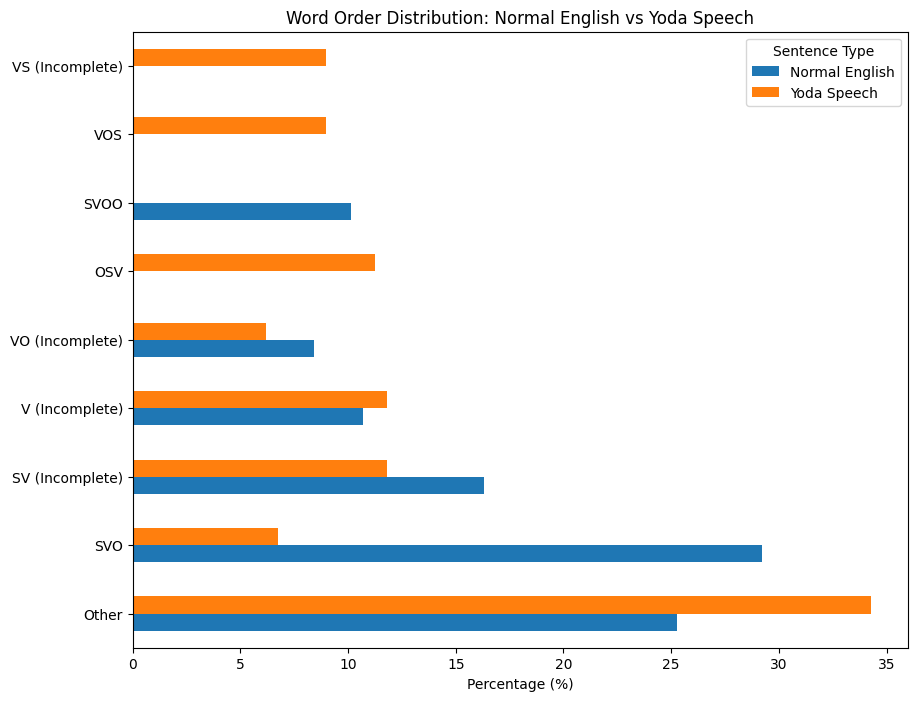

In [26]:
# Compute percentage distributions
normal_counts = word_order_df["normal_word_order"].value_counts(normalize=True) * 100
yoda_counts   = word_order_df["yoda_word_order"].value_counts(normalize=True) * 100

# Combine the distributions
combined_df = pd.DataFrame({
    "Normal English": normal_counts,
    "Yoda Speech": yoda_counts
}).fillna(0)

# Aggregate low-frequency categories: set a threshold (e.g., below 5%)
threshold = 5
def aggregate_low_freq(series, thresh):
    # Separate high frequency and low frequency categories.
    high = series[series >= thresh]
    low = series[series < thresh]
    if not low.empty:
        high["Other"] = low.sum()
    return high

agg_normal = aggregate_low_freq(combined_df["Normal English"], threshold)
agg_yoda   = aggregate_low_freq(combined_df["Yoda Speech"], threshold)

# Align indices of both series for combined plotting
combined_agg = pd.DataFrame({
    "Normal English": agg_normal,
    "Yoda Speech": agg_yoda
}).fillna(0)

# Sort by total frequency
combined_agg["Total"] = combined_agg["Normal English"] + combined_agg["Yoda Speech"]
combined_agg = combined_agg.sort_values("Total", ascending=False)
combined_agg = combined_agg.drop(columns="Total")

# Plot horizontal bar chart
ax = combined_agg.plot(kind="barh", figsize=(10, 8))
ax.set_xlabel("Percentage (%)")
ax.set_title("Word Order Distribution: Normal English vs Yoda Speech")
plt.legend(title="Sentence Type")
plt.show()

In [9]:
# find all rows that yoda word order is "SOV"
yoda_sov = word_order_df[word_order_df["yoda_word_order"] == "VS (Incomplete)"]

yoda_sov

,original,normal_english,mapping,normal_word_order,yoda_word_order
9,rrevealed your opinion is.,Your opinion is rrevealed.,"[1, 2, 3, 0]",SV (Incomplete),VS (Incomplete)
11,tested he will be.,He will be tested.,"[1, 2, 3, 0]",SV (Incomplete),VS (Incomplete)
13,how feel you?,You feel how?,"[2, 1, 0]",SV (Incomplete),VS (Incomplete)
14,afraid are you?,Are you afraid?,"[1, 2, 0]",VS (Incomplete),VS (Incomplete)
22,"then continue, we will.","We will continue, then.","[2, 3, 1, 0]",SV (Incomplete),VS (Incomplete)
24,"clouded, this boy's future is.",This boy's future is clouded.,"[1, 2, 3, 4, 0]",SV (Incomplete),VS (Incomplete)
28,"ready so early, are you?",Are you ready so early?,"[3, 4, 0, 1, 2]",VS (Incomplete),VS (Incomplete)
41,"agree, the council does.",The council does agree.,"[1, 2, 3, 0]",SV (Incomplete),VS (Incomplete)
51,close to you?,you close to?,"[2, 0, 1]",SV (Incomplete),VS (Incomplete)
66,"go, i will.",I will go.,"[1, 2, 0]",SV (Incomplete),VS (Incomplete)


In [10]:
# display row 2 to 5
display(yoda_sov.iloc[1:7][["original", "normal_english", "mapping", "yoda_word_order", "normal_word_order"]])

,original,normal_english,mapping,yoda_word_order,normal_word_order
11,tested he will be.,He will be tested.,"[1, 2, 3, 0]",VS (Incomplete),SV (Incomplete)
13,how feel you?,You feel how?,"[2, 1, 0]",VS (Incomplete),SV (Incomplete)
14,afraid are you?,Are you afraid?,"[1, 2, 0]",VS (Incomplete),VS (Incomplete)
22,"then continue, we will.","We will continue, then.","[2, 3, 1, 0]",VS (Incomplete),SV (Incomplete)
24,"clouded, this boy's future is.",This boy's future is clouded.,"[1, 2, 3, 4, 0]",VS (Incomplete),SV (Incomplete)
28,"ready so early, are you?",Are you ready so early?,"[3, 4, 0, 1, 2]",VS (Incomplete),VS (Incomplete)


In [42]:
normal_sov = word_order_df[word_order_df["normal_word_order"] == "SVOO"]
normal_sov

,original,normal_english,mapping,normal_word_order,yoda_word_order
6,(cont'd) master qui-gon more to say have you?,"You have more to say, master Qui-Gon (cont'd)?","[7, 6, 3, 4, 5, 1, 2, 0]",SVOO,OVS
10,"trained as a jedi, you request for him?",You request for him trained as a jedi?,"[4, 5, 6, 7, 0, 1, 2, 3]",SVOO,OSVO
21,i sense much fear in you.,I sense much fear in you.,"[0, 1, 2, 3, 4, 5]",SVOO,SVOO
36,"confer on you, the level of jedi knight the co...","The coucil does confer on you, the level of je...","[8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7]",SVOO,VOS
39,qui-gon's defiance i sense in you.,I sense qui-gon's defiance in you.,"[2, 3, 0, 1, 4, 5]",SVOO,SV (Incomplete)
54,death is a natural part of life.,Death is a natural part of life.,"[0, 1, 2, 3, 4, 5, 6]",SVOO,SVOO
59,"the shadow of greed, that is.",That is the shadow of greed.,"[4, 5, 0, 1, 2, 3]",SVOO,OOSV
67,"good relations with the wookiees, i have.",I have good relations with the wookiees.,"[5, 6, 0, 1, 2, 3, 4]",SVOO,OOSV
68,"too much under the sway of the chancellor, he is.",He is too much under the sway of the chancellor.,"[8, 9, 0, 1, 2, 3, 4, 5, 6, 7]",SVOO,OOSV
74,"and now destroy the droid armies on kashyyyk, ...","And now, I will destroy the droid armies on Ka...","[0, 1, 8, 9, 2, 3, 4, 5, 6, 7]",SVOO,VOS


In [21]:
import seaborn as sns

Transition Percentage Table (Normal English -> Yoda Speech):
yoda_word_order     OOOSV  OOOV (Incomplete)  OOSV  OOV (Incomplete)  OOVS  \
normal_word_order                                                            
OOSVSO               0.00               0.00  0.00              0.00  0.00   
OSV                  0.00               0.00  0.00              0.00  0.00   
SOSSV                0.00               0.00  0.00              0.00  0.00   
SOSV                 0.00               0.00  0.00              0.00  0.00   
SOV                  0.00               0.00  0.00              0.00  0.00   
SOVO                 0.00               0.00  0.00              0.00  0.00   
SOVOO                0.00               0.00  0.00              0.00  0.00   
SOVSOO               0.00               0.00  0.00              0.00  0.00   
SSV (Incomplete)     0.00               0.00  0.00              0.00  0.00   
SV (Incomplete)      0.00               0.00  0.00              0.00  0.00   
SVO

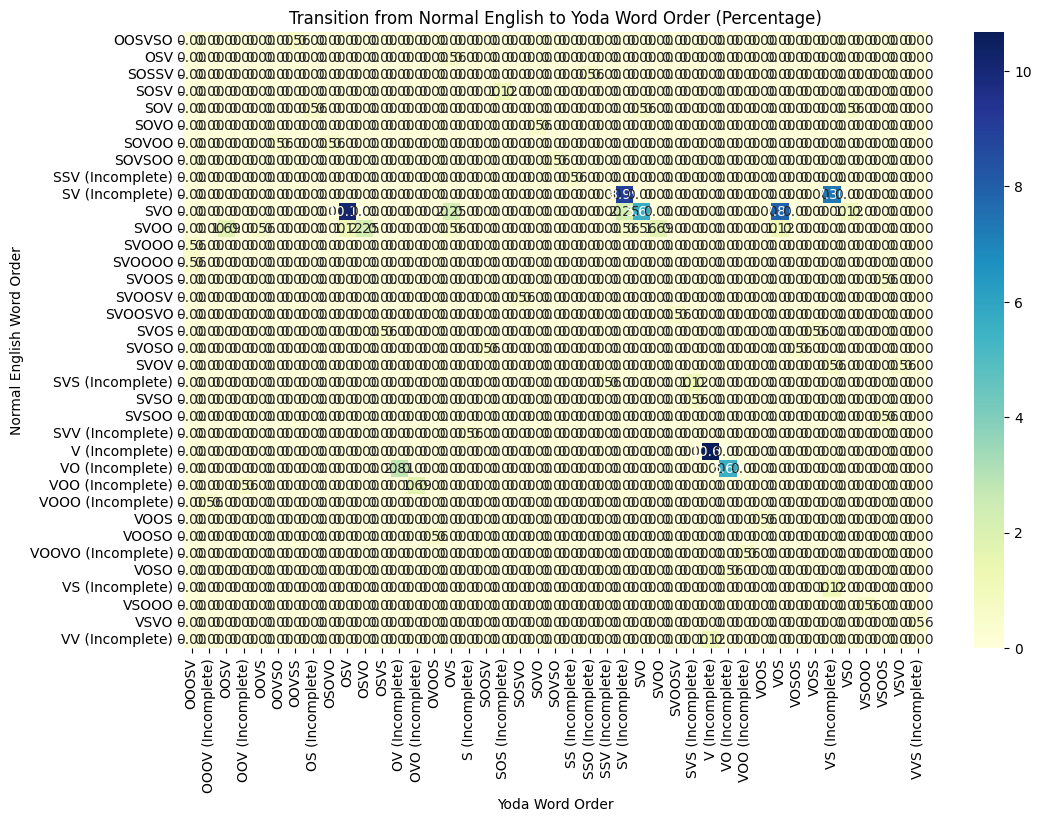

In [23]:
pair_counts = pd.crosstab(word_order_df["normal_word_order"], word_order_df["yoda_word_order"])

# Optionally, convert to percentages relative to total number of sentences.
pair_percentages = pair_counts / pair_counts.sum().sum() * 100

# Display the table of percentages.
print("Transition Percentage Table (Normal English -> Yoda Speech):")
print(pair_percentages.round(2))

# Create a heatmap using seaborn for visualization.
plt.figure(figsize=(12, 8))
sns.heatmap(pair_percentages, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Yoda Word Order")
plt.ylabel("Normal English Word Order")
plt.title("Transition from Normal English to Yoda Word Order (Percentage)")
plt.show()

Significant Transitions (>= 5%):
Normal: V (Incomplete) -> Yoda: V (Incomplete): 10.67%
Normal: SVO -> Yoda: OSV: 10.11%
Normal: SV (Incomplete) -> Yoda: SV (Incomplete): 8.99%
Normal: SVO -> Yoda: VOS: 7.87%
Normal: SV (Incomplete) -> Yoda: VS (Incomplete): 7.30%
Normal: SVO -> Yoda: SVO: 5.62%
Normal: VO (Incomplete) -> Yoda: VO (Incomplete): 5.62%

Detailed Significant Transitions:
            Normal             Yoda  Percentage
0   V (Incomplete)   V (Incomplete)   10.674157
1              SVO              OSV   10.112360
2  SV (Incomplete)  SV (Incomplete)    8.988764
3              SVO              VOS    7.865169
4  SV (Incomplete)  VS (Incomplete)    7.303371
5              SVO              SVO    5.617978
6  VO (Incomplete)  VO (Incomplete)    5.617978


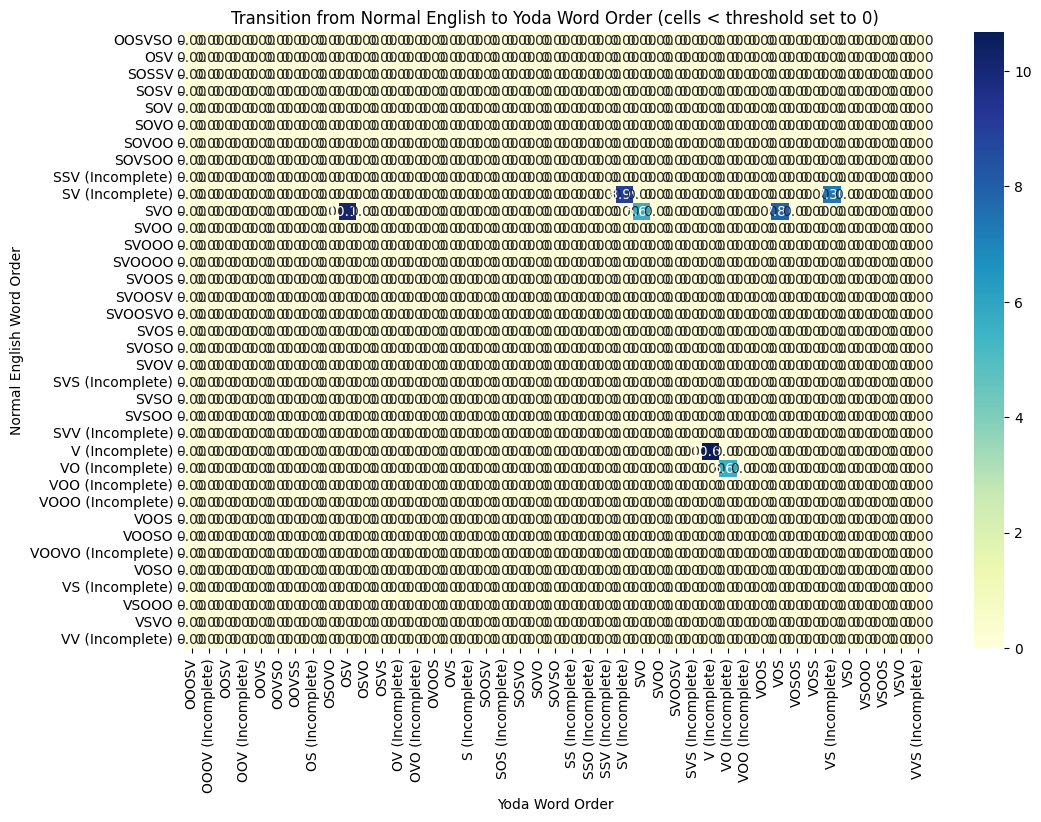

In [24]:
ct = pd.crosstab(word_order_df["normal_word_order"], word_order_df["yoda_word_order"])
total = ct.sum().sum()
pct = ct / total * 100

# Set a threshold for significance (e.g., 5%)
threshold = 5

# Collect significant transitions: if either group's transition percentage is >= threshold,
# we record that cell.
significant_pairs = []
for normal_order in pct.index:
    for yoda_order in pct.columns:
        value = pct.loc[normal_order, yoda_order]
        if value >= threshold:
            significant_pairs.append((normal_order, yoda_order, value))

# Sort the significant pairs by percentage descending
significant_pairs = sorted(significant_pairs, key=lambda x: x[2], reverse=True)

print(f"Significant Transitions (>= {threshold}%):")
for normal, yoda, value in significant_pairs:
    print(f"Normal: {normal} -> Yoda: {yoda}: {value:.2f}%")

# Optionally, create a DataFrame of significant transitions
sig_df = pd.DataFrame(significant_pairs, columns=["Normal", "Yoda", "Percentage"])
print("\nDetailed Significant Transitions:")
print(sig_df)

# For visualization, we can also plot a heatmap where cells below the threshold are zeroed.
heatmap_data = pct.copy()
heatmap_data[heatmap_data < threshold] = 0

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Transition from Normal English to Yoda Word Order (cells < threshold set to 0)")
plt.xlabel("Yoda Word Order")
plt.ylabel("Normal English Word Order")
plt.show()